## Import modules

In [36]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch

from scipy import stats
from torchvision import transforms
from torch.utils.data import DataLoader

sys.path.append('d:/gsn-projekt')

import amphibian.preprocess.preprocessing as preproc
from amphibian.fetch.reader import AmphibianReader
from amphibian.preprocess.train_test_split import TrainTestSplit
from amphibian.architectures import RNNModel, AttentionModel
from amphibian.train import SingleTrainer, batch_size_dist

## Parameters

In [28]:
WINDOW_WIDTH = 10
PARAM_GRID_RNN = {
    'batch_size': batch_size_dist(32, 256),
    'seq_len': stats.randint(10, 11),
    'input_size': stats.randint(126, 127),
    'hidden_size': stats.randint(5, 20),
    'n_outputs': stats.randint(3,4),
    'num_layers': stats.randint(3,4),
    'dropout': stats.uniform(0.5, 0.3)
}

In [3]:
for k,v in PARAM_GRID_RNN.items():
    print(k, v.rvs(size=1)[0])

batch_size 128
seq_len 10
input_size 126
hidden_size 8
n_outputs 3
num_layers 3
dropout 1.2953241610958002


## Read data

In [4]:
DATA_PATH = r'D:\gsn-projekt\data\all_values\stocks\Auto Manufacturers - Major'

ar = AmphibianReader(DATA_PATH, datetime.datetime(2011, 1, 1), datetime.datetime(2018, 1, 1))

_ = ar.create_torch()

## Train test split

In [5]:
tts = TrainTestSplit(ar, int_start=0, int_end=1000)

In [6]:
tsds = preproc.TimeSeriesDataset(tts, int_len=WINDOW_WIDTH, transform=transforms.Compose([
    preproc.FillNaN(), preproc.Normalizing(), preproc.DummyFillNaN(), preproc.Formatting(), 
    preproc.FormattingY()
]))

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [7]:
tsds.whole_set['train_y'].size(1)

95

In [8]:
tsds.len_train * 95

75145

In [9]:
tsds[75144]

{'train_obs': tensor([[ 0.3100, -0.6336,  2.2020,  ...,  1.8890,  1.7051,  2.8049],
         [ 0.2960, -0.6810,  2.2020,  ...,  1.8207,  1.7037,  3.2221],
         [ 0.2397, -0.6810,  2.2020,  ...,  1.9070,  1.7358,  3.0237],
         ...,
         [ 0.1554, -0.6810,  2.2020,  ...,  2.0451,  1.7942,  2.6828],
         [ 0.1413, -0.7283,  2.2020,  ...,  2.0059,  1.7037,  2.6828],
         [ 0.0710, -0.7283,  2.2020,  ...,  1.7987,  1.4628,  2.3775]],
        device='cuda:0'), 'train_y': tensor(0, device='cuda:0')}

## Batch check

In [29]:
sampled_params = {}
for k, v in PARAM_GRID_RNN.items():
    s = v.rvs(size=1)[0]
    if s.dtype == float:
        sampled_params[k] = float(s)
    else:
        sampled_params[k] = int(s)

In [11]:
dl = DataLoader(tsds, batch_size=256, shuffle=True)

In [12]:
for i, batch in enumerate(dl):
    break #print(batch['train_obs'].size())

In [13]:
vds = preproc.ValidDataset(tsds)

In [14]:
len(vds)

18145

In [15]:
vds[18144]

{'test_obs': tensor([[ 0.2257, -0.6336,  1.7779,  ...,  3.7820,  5.2672, 20.6378],
         [ 0.1976, -0.6810,  1.7514,  ...,  3.8892,  5.3069, 22.2276],
         [ 0.3100, -0.6810,  1.7514,  ...,  4.1682,  5.4980, 21.6737],
         ...,
         [ 0.2679, -0.6336,  1.6189,  ...,  4.2793,  5.6861, 21.5814],
         [ 0.2257, -0.5863,  1.7514,  ...,  4.2911,  5.6420, 21.8737],
         [ 0.3522, -0.5863,  1.7514,  ...,  4.4313,  5.8640, 22.0891]],
        device='cuda:0'), 'test_y': tensor(2, device='cuda:0')}

In [16]:
vds[1]['test_obs'].shape

torch.Size([10, 126])

## Single training

In [30]:
print(sampled_params)

{'batch_size': 64, 'seq_len': 10, 'input_size': 126, 'hidden_size': 7, 'n_outputs': 3, 'num_layers': 3, 'dropout': 0.6246375484356165}


In [31]:
rnnmodel = RNNModel(**sampled_params)
st = SingleTrainer(rnnmodel, batch_size=sampled_params['batch_size'], early_stopping_patience=20, learning_rate=0.01)

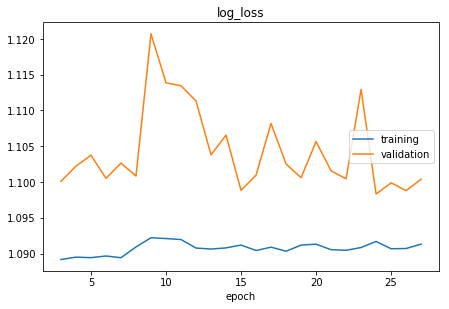

log_loss:
training   (min:    1.089, max:    1.092, cur:    1.091)
validation (min:    1.098, max:    1.121, cur:    1.100)


KeyboardInterrupt: 

In [32]:
st.train(tsds, vds, verbose=False)

## Single training Attention

In [34]:
sampled_params_attn = sampled_params
sampled_params_attn['recurrent_type'] = 'lstm'
sampled_params_attn['alignment'] = 'ffnn'

In [39]:
attnmodel = AttentionModel(**sampled_params)
st_attn = SingleTrainer(attnmodel, batch_size = sampled_params['batch_size'], learning_rate=1e-3)

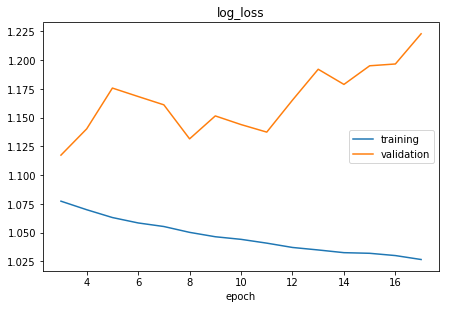

log_loss:
training   (min:    1.027, max:    1.088, cur:    1.027)
validation (min:    1.098, max:    1.223, cur:    1.223)


In [ ]:
st_attn.train(tsds, vds, verbose=False)